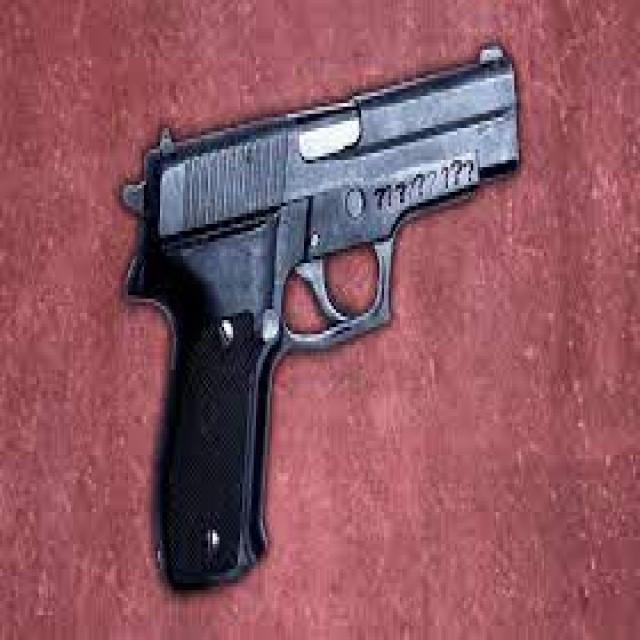

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset

# Replace with your dataset containing question-answer pairs related to breast cancer
# Format of the dataset: [{'question': '...', 'answer': '...'}, ...]
dataset = [
    {'question': 'What is breast cancer?', 'answer': 'Breast cancer is a type of cancer that develops in the cells of the breast.'},
    # Add more question-answer pairs
    # {'question': '...', 'answer': '...'},
]

# Define a custom dataset class
class QADataset(Dataset):
    def __init__(self, tokenizer, dataset):
        self.tokenizer = tokenizer
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        item = self.dataset[index]
        question = item['question']
        answer = item['answer']

        inputs = self.tokenizer.encode_plus(question, answer, add_special_tokens=True, return_tensors="pt")
        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "start_positions": torch.tensor([0]),  # Always 0 since we have only one answer span
            "end_positions": torch.tensor([len(inputs["input_ids"][0]) - 1])  # Set to the length of the input sequence
        }

# Load the pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad")
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad")

# Prepare the data loader
train_dataset = QADataset(tokenizer, dataset)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Prepare the optimizer and scheduler
num_epochs = 3  # Number of epochs for fine-tuning (You can change this value as needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tuning loop
for epoch in range(num_epochs):
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

# Save the fine-tuned model
model.save_pretrained("fine_tuned_breast_cancer_model")
tokenizer.save_pretrained("fine_tuned_breast_cancer_model")